In [470]:
import cv2
import matplotlib.pyplot as plt

Original image provided:

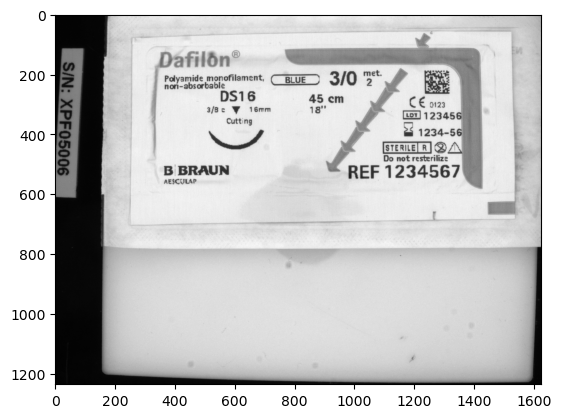

In [471]:
image = cv2.imread('original.bmp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')

Test image provided:

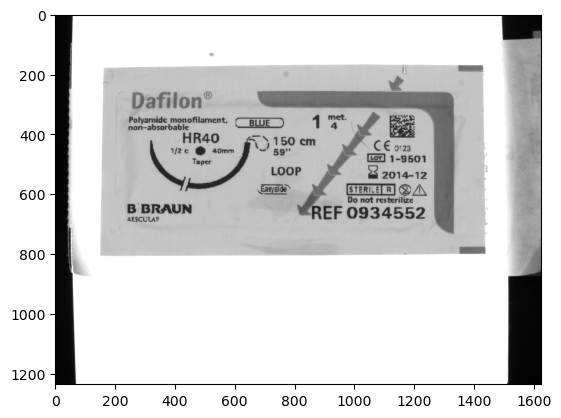

In [472]:
image_test = cv2.imread('perfecta-test.bmp')
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
plt.imshow(image_test, cmap='gray')

We observe that the scale of the images is not the same and that both have background.

Our approach will be to reescale the test image to match the original one and then use hard coded pixel to cut out the numbers and detect them

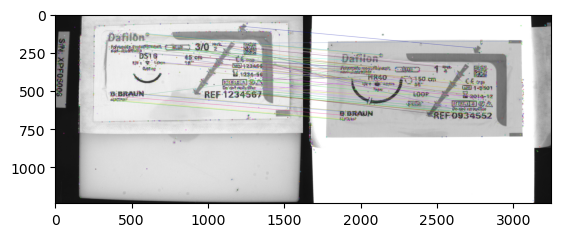

In [473]:
sift = cv2.SIFT_create()

#for feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

kp_or, des_or = sift.detectAndCompute(image,None)
kp_test, des_test = sift.detectAndCompute(image_test,None)

matches = bf.match(des_or,des_test)
matches = sorted(matches,key=lambda x:x.distance)

img = cv2.drawMatches(image,kp_or,image_test,kp_test,matches[300:360],image_test)
plt.imshow(img,cmap="gray")

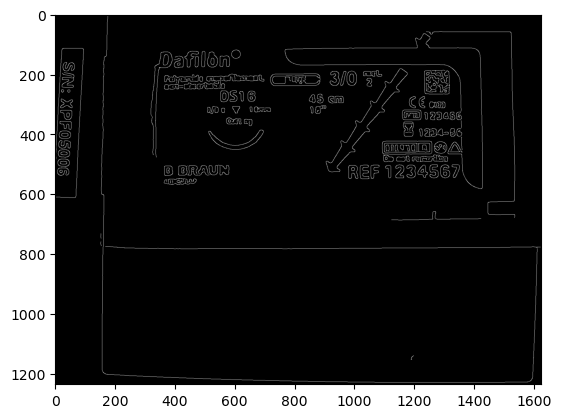

In [455]:
#Apply canny edge detector
edges = feature.canny(image, sigma=3)
plt.imshow(edges,cmap="gray") #we use default hysteresis thresholds

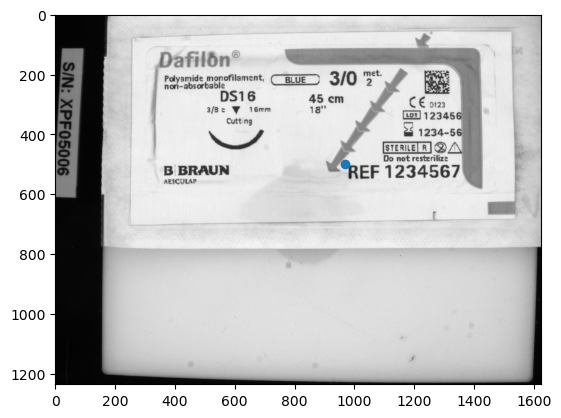

In [474]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

template = image[500:555,970:1090]

res = cv.matchTemplate(image,template,cv.TM_CCOEFF_NORMED)
threshold = 0.8

res[np.where( res <= threshold)] = 0
res[np.where( res > threshold)] = 255

refs = (np.where(res == np.max(res)))
ref_point = [refs[0][0],refs[1][0]]

plt.imshow(image,cmap="gray")
plt.scatter(ref_point[1],ref_point[0])
plt.show()

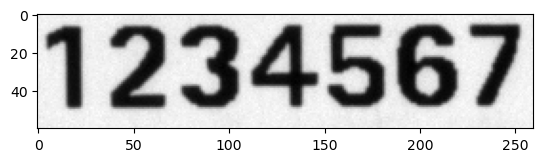

In [457]:
numbers = image[ref_point[0]:ref_point[0]+60, ref_point[1]+130:ref_point[1]+390]
plt.imshow(numbers,cmap="gray")

Once we have the numbers we can proceed to detect which ones are what

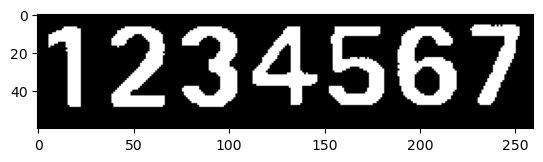

In [458]:
#Apply binary threshold
#first of all threshold the image to convert it to binary
(thresh, numbers) = cv2.threshold(numbers, 120, 255, cv2.THRESH_BINARY)

#invert image
numbers = (numbers*-1)+255
plt.imshow(numbers,cmap="gray")

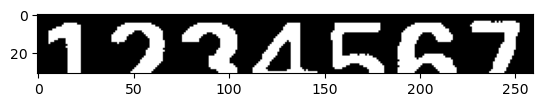

In [459]:

plt.imshow(numbers[2:33,:],cmap="gray")

In [460]:
def crop_to_edges(image):
    #along y axis
    fin_image = image
    squished_image = np.sum(image,axis=1)
    start_idx = None
    for i, val in enumerate(squished_image):
        if val > 0:
            if(start_idx == None): #look for first not 0 pixel
                start_idx = i#set start index
        
        elif(start_idx != None): #if found 0 pixel and start_idx set
            fin_image = image[start_idx:i,:] #crop image
            break
    
        if(i+1 == len(squished_image) and start_idx != None): #if finished iterating and start_idx set
            fin_image = image[start_idx:i,:] #crop image
            break

    #along x axis
    squished_image = np.sum(image,axis=0)
    start_idx = None
    for i, val in enumerate(squished_image):
        if val > 0:#look for first not 0 pixel
            if(start_idx == None):
                start_idx = i#set start index

        elif(start_idx != None):#if found 0 pixel and start_idx set
            return fin_image[:,start_idx:i] #crop image and end           
        
        if(i+1 == len(squished_image) and start_idx != None): #if finished iterating and start_idx set
            return fin_image[:,start_idx:i] #crop image
        
        if(i+1 == len(squished_image) and start_idx == None):
            print(i)
            return fin_image
        
    

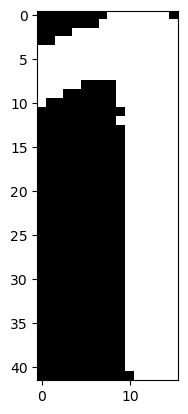

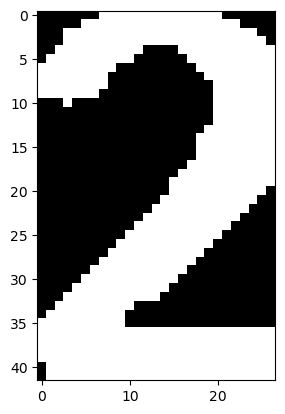

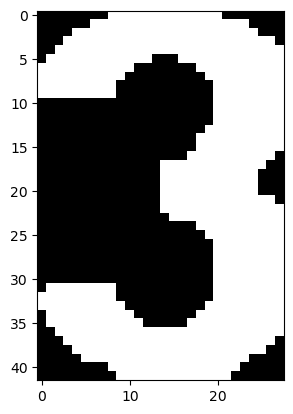

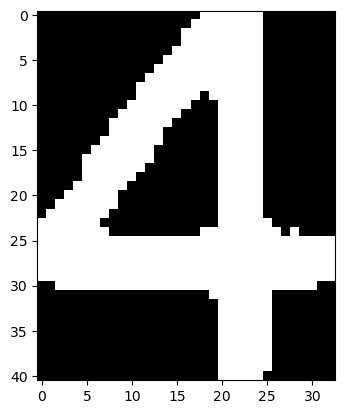

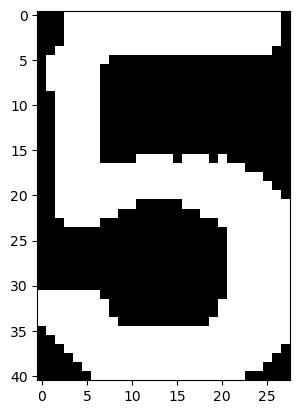

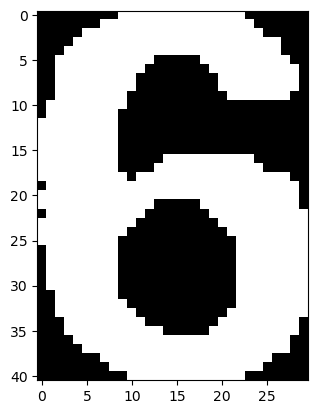

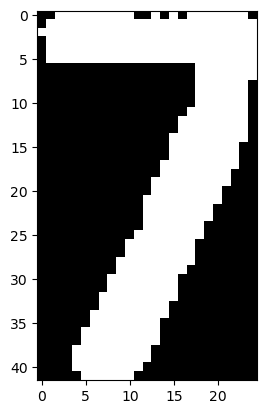

In [461]:
#Now we'll do a column-wise scan to check where numbers start and end so we can get them cut().
squished_image = np.sum(numbers,axis=0)

#we'll store here the cropped number images
digits = []
cnt = 0
start_idx = None
for i, val in enumerate(squished_image):
    if val > 0:
        if(start_idx == None):
            start_idx = i
    
    elif(start_idx != None):
        digits.append(numbers[:,start_idx:i])
        start_idx = None

fin_digits = []
for digit in digits:
    fin_digits.append(crop_to_edges(digit))

for digit in fin_digits:
    plt.imshow(digit,cmap="gray")
    plt.show()

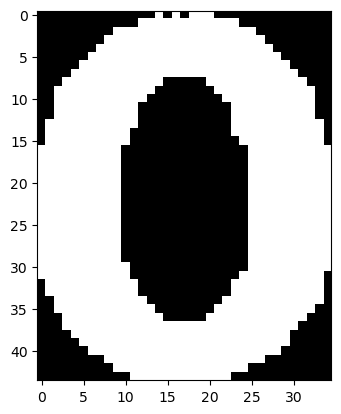

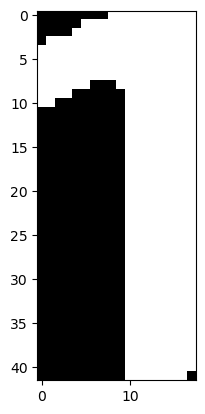

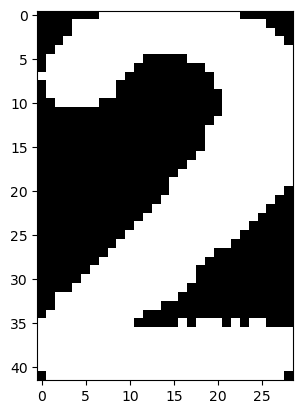

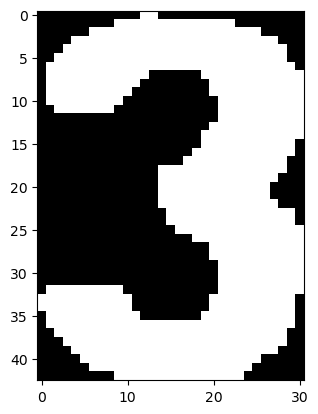

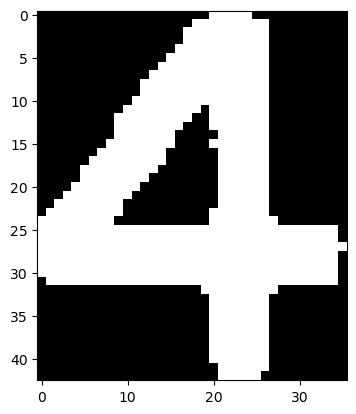

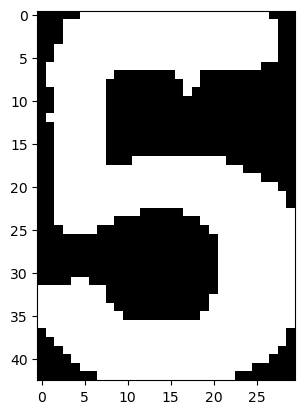

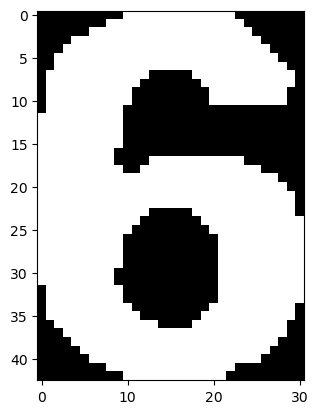

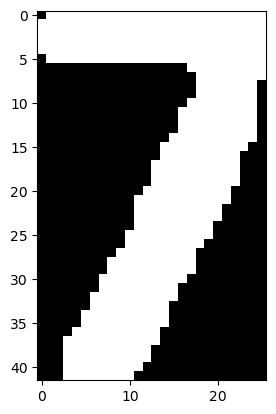

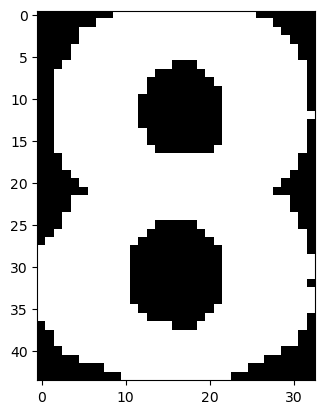

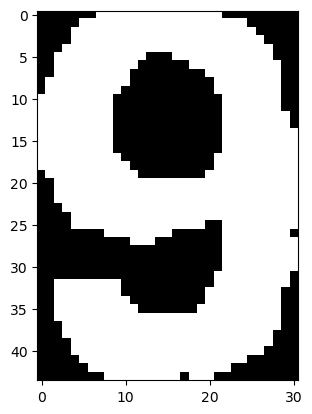

In [484]:
#load template images
templates = []
for i in range(10):
    #load template images
    templ = cv2.imread(f'NUMBERS/{i}.bmp')
    templ = cv2.cvtColor(templ, cv2.COLOR_BGR2GRAY)
    
    #apply same threshold
    (thresh, templ) = cv2.threshold(templ, 120, 255, cv2.THRESH_BINARY)
    templ = (templ*-1)+255 #invert image
    templ = crop_to_edges(templ) #crop image
    templates.append(templ)
    plt.imshow(templ,cmap="gray")
    plt.show()

In [480]:
def eval_digits(digit,templates):
    eval_digit = np.zeros(len(templates))  #we will store match value for each template for the provided digit
    for t , template in enumerate(templates): #iterate through all templates
        d_h , d_w = digit.shape
        dig_cpy = digit.copy()
        t_h , t_w = template.shape
        tem_cpy = template.copy()
        w_diff = abs(d_w-t_w)
        h_diff = abs(d_h-t_h)

        if(w_diff != 0): #if width between images doesn't match
            if d_w > t_w: #if digit is wider than template
                if w_diff % 2 == 0: #if we can split difference equally on either side
                    tem_cpy = cv2.copyMakeBorder(tem_cpy, top=0, bottom=0, left = int(w_diff/2), right= int(w_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)
                else: # if indivisible equally put half and hald but left border has one extra
                    tem_cpy = cv2.copyMakeBorder(tem_cpy, top=0, bottom=0, left = int(w_diff/2)+1, right = int(w_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)
            else: # t_w > d_w
                if w_diff % 2 == 0: #if we can split difference equally on either side
                    dig_cpy = cv2.copyMakeBorder(dig_cpy, top=0, bottom=0, left = int(w_diff/2), right = int(w_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)
                else: # if indivisible equally put half and hald but left border has one extra
                    dig_cpy = cv2.copyMakeBorder(dig_cpy, top=0, bottom=0, left = int(w_diff/2)+1, right = int(w_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)
        
        if(h_diff != 0): #if width between images doesn't match
            if d_h > t_h: #if digit is wider than template
                if h_diff % 2 == 0: #if we can split difference equally on either side
                    tem_cpy = cv2.copyMakeBorder(tem_cpy, left=0, right=0, top = int(h_diff/2), bottom = int(h_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)
                else: # if indivisible equally put half and hald but left border has one extra
                    tem_cpy = cv2.copyMakeBorder(tem_cpy,left=0,right=0,top = int(h_diff/2)+1, bottom = int(h_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)
            else: # t_h > d_h
                if h_diff % 2 == 0: #if we can split difference equally on either side
                    dig_cpy = cv2.copyMakeBorder(dig_cpy, left=0, right=0, top = int(h_diff/2), bottom = int(h_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)
                else: # if indivisible equally put half and hald but left border has one extra
                    dig_cpy = cv2.copyMakeBorder(dig_cpy, left=0, right=0, top = int(h_diff/2)+1, bottom = int(h_diff/2), value=0, borderType=cv2.BORDER_CONSTANT)

        eval_digit[t]  = np.mean(dig_cpy == tem_cpy) #mean of how many match for that template

    match = np.where(eval_digit == np.max(eval_digit))[0][0] #number with bigger match
    return eval_digit, templates[match], match 


Digit: 


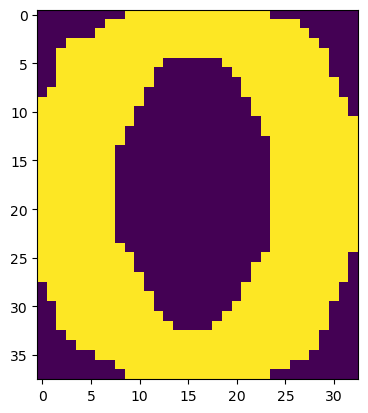

Template max: 
NUMBER DETECTED:  0


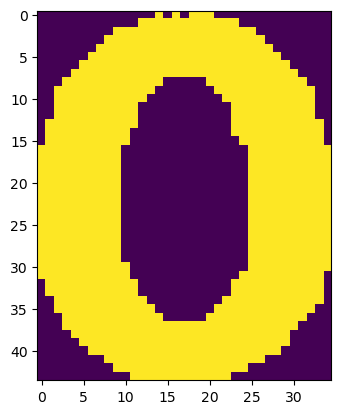


Digit: 


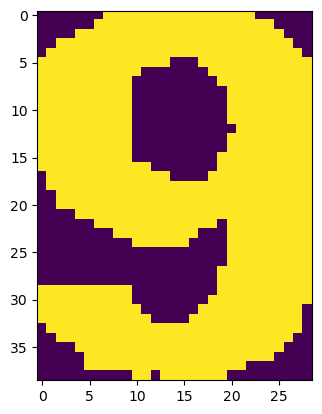

Template max: 
NUMBER DETECTED:  9


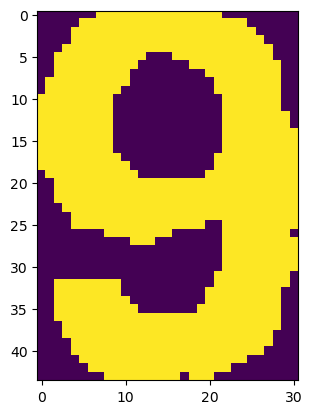


Digit: 


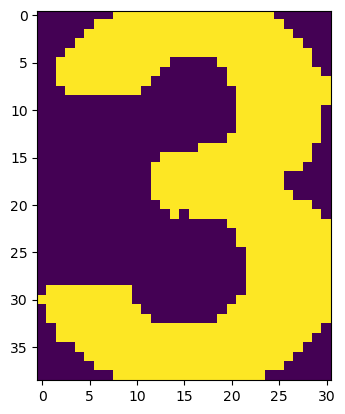

Template max: 
NUMBER DETECTED:  3


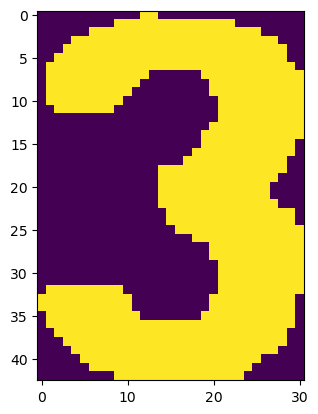


Digit: 


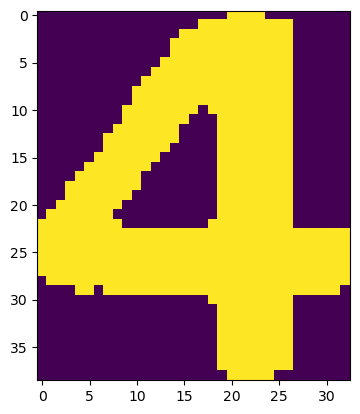

Template max: 
NUMBER DETECTED:  4


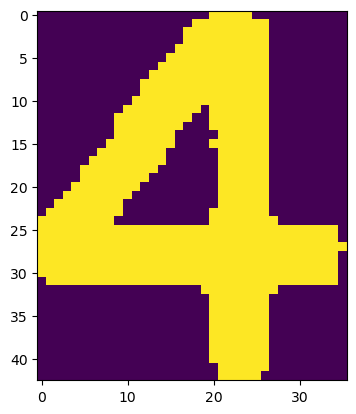


Digit: 


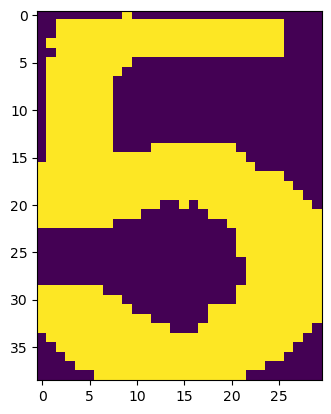

Template max: 
NUMBER DETECTED:  5


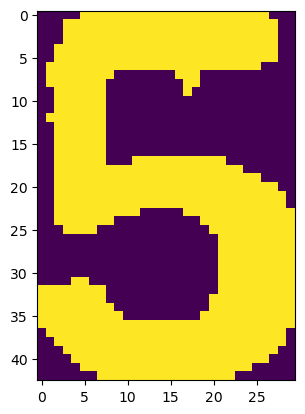


Digit: 


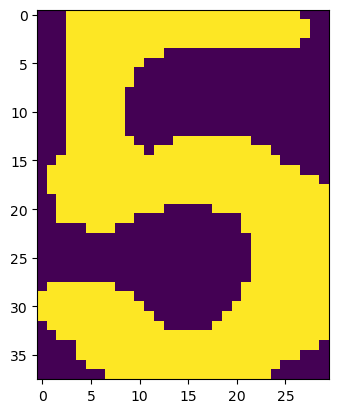

Template max: 
NUMBER DETECTED:  5


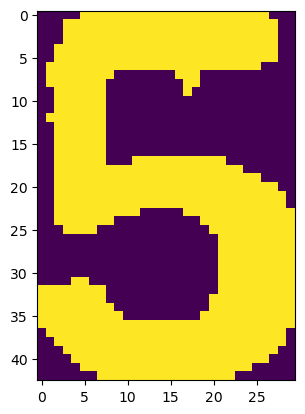


Digit: 


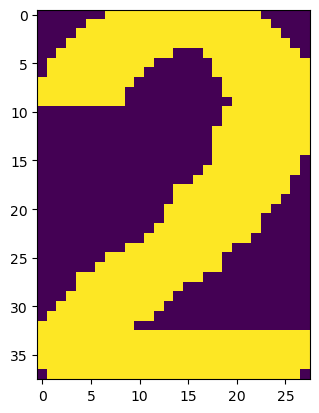

Template max: 
NUMBER DETECTED:  2


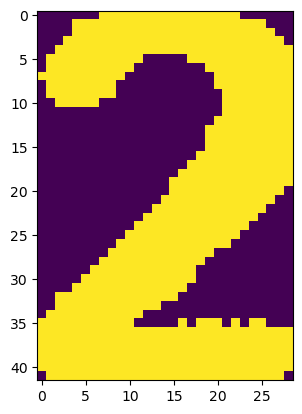

In [486]:
for digit in fin_digits:
    print("Digit: ")
    plt.imshow(digit)
    plt.show()
    print("Template max: ")
    eval_digit, template_match, match = eval_digits(digit,templates)
    print("NUMBER DETECTED: ",match)
    plt.imshow(template_match)
    plt.show()
    print("")

Now on test image:

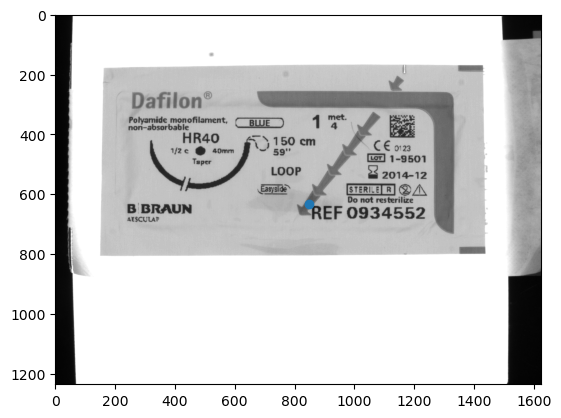

In [475]:
res = cv.matchTemplate(image_test,template,cv.TM_CCOEFF_NORMED)
threshold = 0.8

res[np.where( res <= threshold)] = 0
res[np.where( res > threshold)] = 255

refs = (np.where(res == np.max(res)))
ref_point = [refs[0][0],refs[1][0]]

plt.imshow(image_test,cmap="gray")
plt.scatter(ref_point[1],ref_point[0])
plt.show()

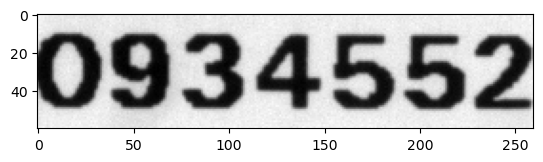

In [476]:
numbers = image_test[ref_point[0]:ref_point[0]+60, ref_point[1]+130:ref_point[1]+390]
plt.imshow(numbers,cmap="gray")

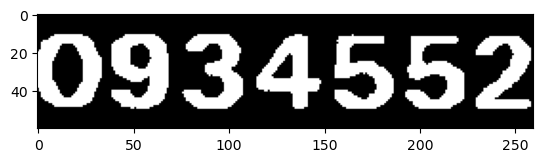

In [477]:
#Apply binary threshold
#first of all threshold the image to convert it to binary
(thresh, numbers) = cv2.threshold(numbers, 120, 255, cv2.THRESH_BINARY)

#invert image
numbers = (numbers*-1)+255
plt.imshow(numbers,cmap="gray")

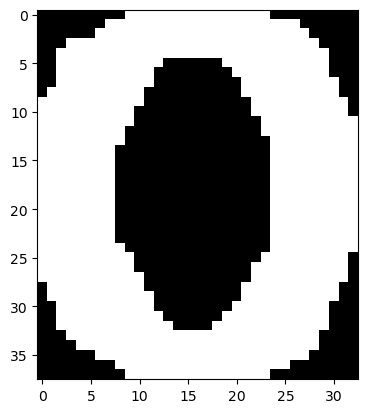

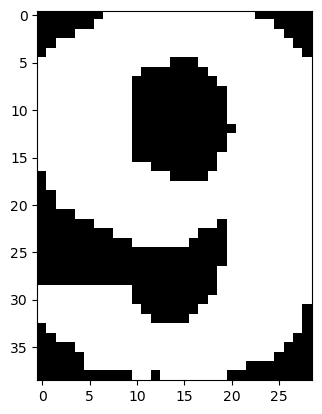

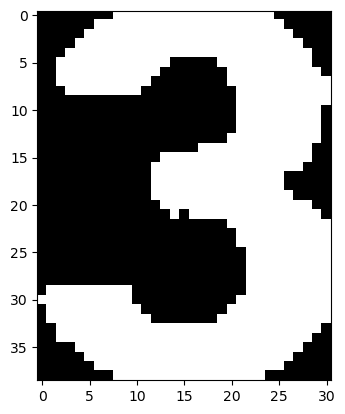

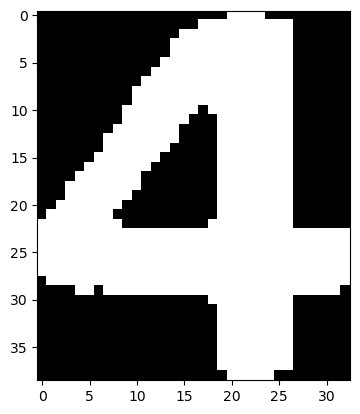

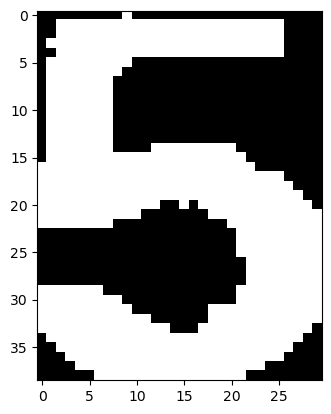

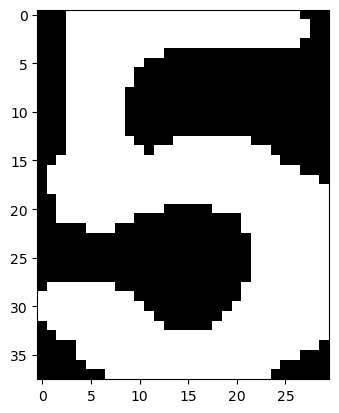

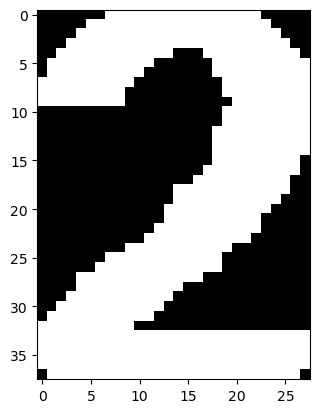

In [489]:
#Now we'll do a column-wise scan to check where numbers start and end so we can get them cut().
squished_image = np.sum(numbers,axis=0)

#we'll store here the cropped number images
digits = []
cnt = 0
start_idx = None
for i, val in enumerate(squished_image):
    if val > 0:
        if(start_idx == None):
            start_idx = i
    
    elif(start_idx != None):
        digits.append(numbers[:,start_idx:i])
        start_idx = None

clean_digits = []
for digit in digits:
    clean_digits.append(crop_to_edges(digit))

for digit in clean_digits:
    plt.imshow(digit,cmap="gray")
    plt.show()

Digit: 


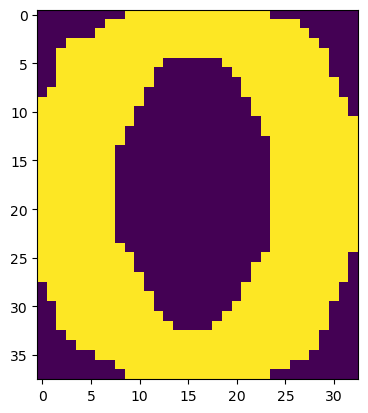

Template max: 
NUMBER DETECTED:  0


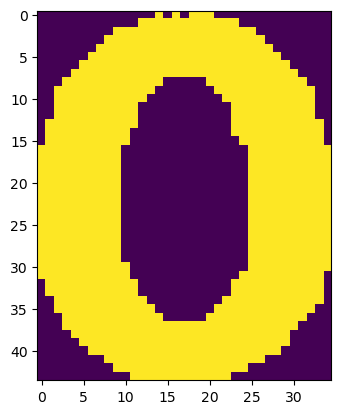


Digit: 


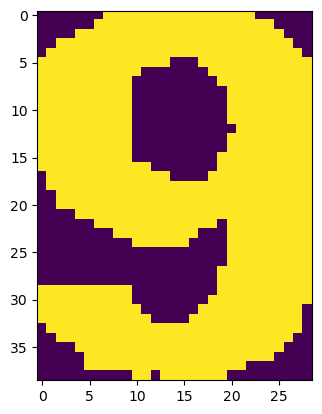

Template max: 
NUMBER DETECTED:  9


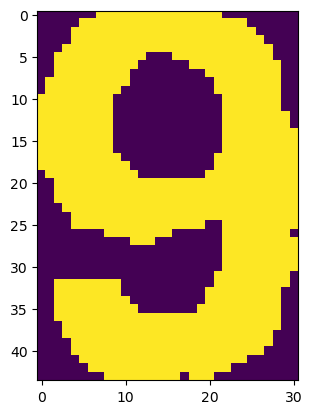


Digit: 


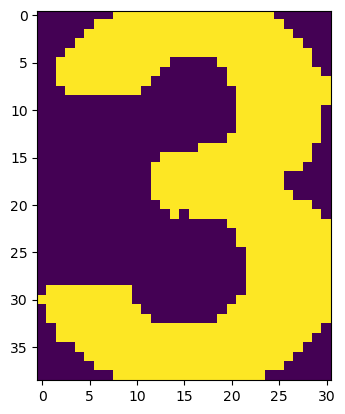

Template max: 
NUMBER DETECTED:  3


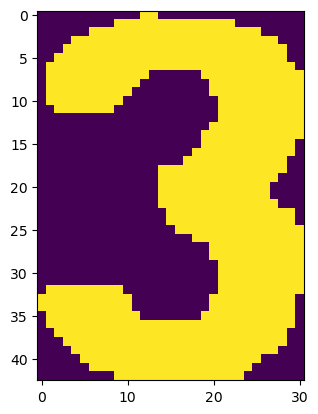


Digit: 


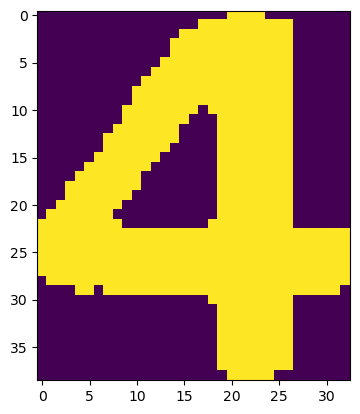

Template max: 
NUMBER DETECTED:  4


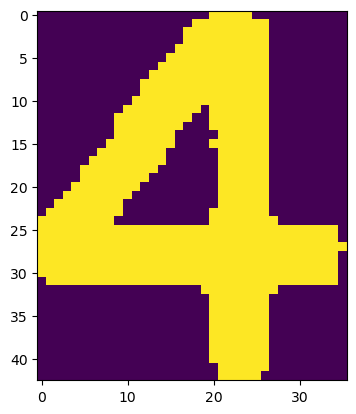


Digit: 


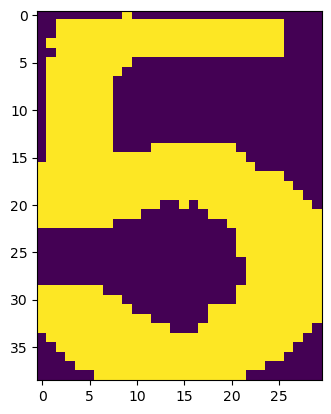

Template max: 
NUMBER DETECTED:  5


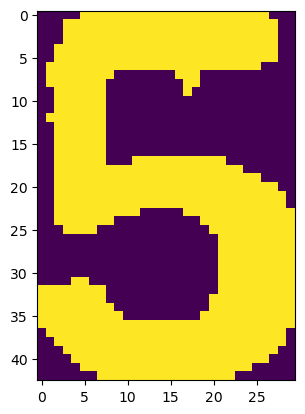


Digit: 


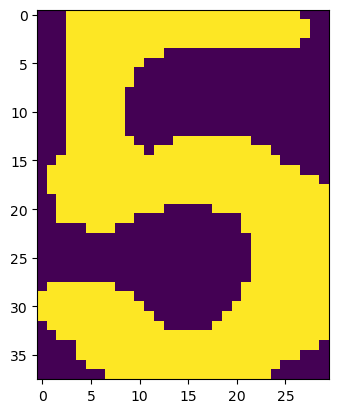

Template max: 
NUMBER DETECTED:  5


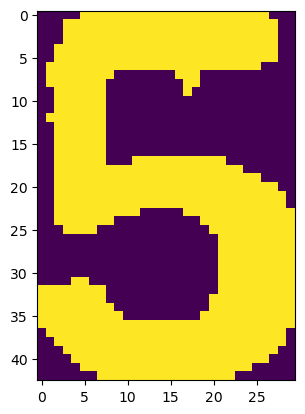


Digit: 


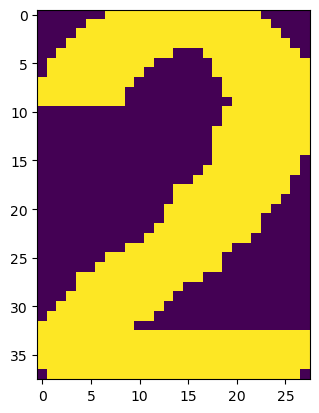

Template max: 
NUMBER DETECTED:  2


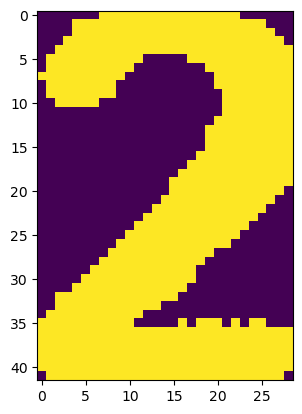

In [490]:
for digit in clean_digits:
    print("Digit: ")
    plt.imshow(digit)
    plt.show()
    print("Template max: ")
    eval_digit, template_match, match = eval_digits(digit,templates)
    print("NUMBER DETECTED: ",match)
    plt.imshow(template_match)
    plt.show()
    print("")